In [1]:
import numpy as np
import pandas as pd
import io
import requests
import seaborn as sns
from matplotlib import pyplot as plt
import pickle
from pandas.api.types import CategoricalDtype

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import cross_val_score

%matplotlib inline

In [4]:
columns = ["age", "workClass", "fnlwgt", "education", "education-num",
           "marital-status", "occupation", "relationship", "race", "sex", 
           "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"]

train_data = pd.read_csv('/content/sample_data/adult.data', names = columns, sep=' *, *', na_values='?')
test_data = pd.read_csv('/content/sample_data/adult.test', names = columns, sep=' *, *', skiprows =1, na_values='?')

<ipython-input-4-fd29261b13a8>:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  train_data = pd.read_csv('/content/sample_data/adult.data', names = columns, sep=' *, *', na_values='?')
<ipython-input-4-fd29261b13a8>:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  test_data = pd.read_csv('/content/sample_data/adult.test', names = columns, sep=' *, *', skiprows =1, na_values='?')


In [5]:
train_data.head()

,age,workClass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [6]:
test_data.head()

,age,workClass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K.


# EDA and FE

~ Cleaning the data

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workClass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


~ Observations:

• There are in total 32561 samples in the train data set. 

• There are both categorical and numerical attributes in the dataset. 

• The columns workClass, occupation, native-country have missing values

In [8]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             16281 non-null  int64 
 1   workClass       15318 non-null  object
 2   fnlwgt          16281 non-null  int64 
 3   education       16281 non-null  object
 4   education-num   16281 non-null  int64 
 5   marital-status  16281 non-null  object
 6   occupation      15315 non-null  object
 7   relationship    16281 non-null  object
 8   race            16281 non-null  object
 9   sex             16281 non-null  object
 10  capital-gain    16281 non-null  int64 
 11  capital-loss    16281 non-null  int64 
 12  hours-per-week  16281 non-null  int64 
 13  native-country  16007 non-null  object
 14  income          16281 non-null  object
dtypes: int64(6), object(9)
memory usage: 1.9+ MB


~ Observations:

• There are in total 16281 samples in the test data set. 

• There are both categorical and numerical attributes in the dataset.
 
• There are no missing values.

~ Handling numerical values:

In [9]:
num_values = train_data.select_dtypes(include=['int'])
print(num_values.columns)

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')


~ The variables age, hours-per-week are self-explanatory.

• fnlwgt: sampling weight

• ** education-num**: number of years of education in total

• capital-gain/capital-loss: income from investment sources other than salary/wages

• fnlwgt is not related to the target variable income and can be removed.

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'fnlwgt'}>],
       [<Axes: title={'center': 'education-num'}>,
        <Axes: title={'center': 'capital-gain'}>],
       [<Axes: title={'center': 'capital-loss'}>,
        <Axes: title={'center': 'hours-per-week'}>]], dtype=object)

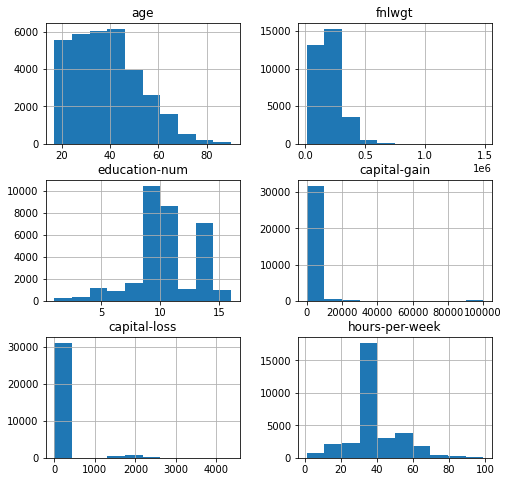

In [10]:
num_values.hist(figsize=(8,8))

In [11]:
num_values.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


~ Observations:

• None of the numerical attributes have missing values. 

• The values are on different scales. Many machine learning models require the features to be on the same scale.

• We can see that there are many outliers present in the data, we will use StandardScaler from sklearn library.

Handling Categorical values:

In [12]:
cate_values = train_data.select_dtypes(include=['object'])
print(cate_values.columns)

Index(['workClass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country', 'income'],
      dtype='object')


<Axes: xlabel='count', ylabel='workClass'>

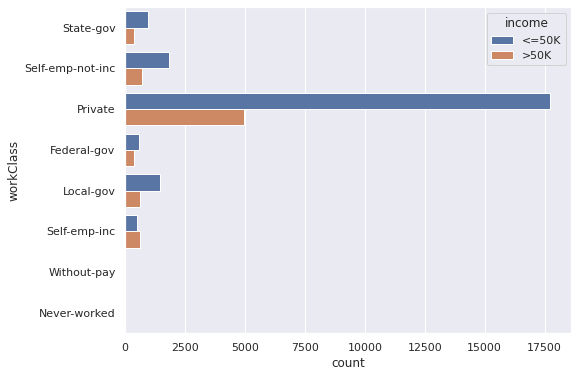

In [14]:
sns.set(rc={'figure.figsize':(8,6)})
sns.countplot(y='workClass', hue='income', data = cate_values)

<Axes: xlabel='count', ylabel='occupation'>

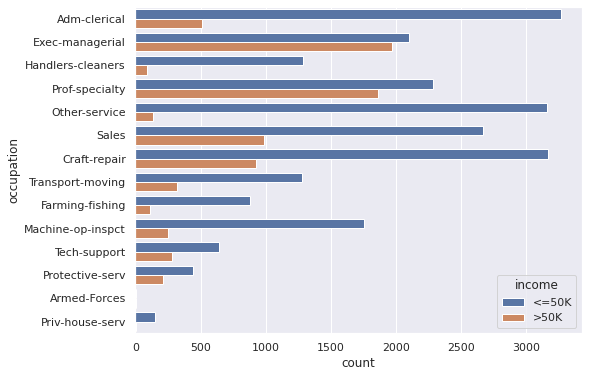

In [15]:
sns.countplot(y='occupation', hue='income', data=cate_values)

~ Observations

• All the variables are self-explanatory.

• The column education is just a string representation of the column education-num. We will drop the education column. 

• The variables workClass, occupation, native-country have missing values. We will replace the missing values in each column with the most_frequent occurring value of that column.

~ We need to handle the numerical and categorical attributes differently. Numerical attributes needs to be scaled, where as we need to fill the missing values and then encode the categorical values into numerical values. To apply these sequence of transformations we will use the sklearn Pipeline. We will also build custom transformers that can be directly used with Pipeline.

~ Creating Pipelines:-

Column selector pipeline -

In [17]:
class ColumnsSelector(BaseEstimator, TransformerMixin):
  
  def __init__(self, type):
    self.type = type
  
  def fit(self, X, y=None):
    return self
  
  def transform(self,X):
    return X.select_dtypes(include=[self.type])

Numerical data pipeline -

In [18]:
num_pipeline = Pipeline(steps=[
    ("num_attr_selector", ColumnsSelector(type='int')),
    ("scaler", StandardScaler())
])

Categorical data pipeline -

Handling missing values first -

In [21]:
class CategoricalImputer(BaseEstimator, TransformerMixin):
  
  def __init__(self, columns = None, strategy='most_frequent'):
    self.columns = columns
    self.strategy = strategy
    
    
  def fit(self,X, y=None):
    if self.columns is None:
      self.columns = X.columns
    
    if self.strategy == 'most_frequent':
      self.fill = {column: X[column].value_counts().index[0] for column in self.columns}
    else:
      self.fill ={column: '0' for column in self.columns}
      
    return self
      
  def transform(self,X):
    X_copy = X.copy()
    for column in self.columns:
      X_copy[column] = X_copy[column].fillna(self.fill[column])
    return X_copy

Encoding categorical values to numerical -

In [22]:
class CategoricalEncoder(BaseEstimator, TransformerMixin):
  
  def __init__(self, dropFirst=True):
    self.categories=dict()
    self.dropFirst=dropFirst
    
  def fit(self, X, y=None):
    join_df = pd.concat([train_data, test_data])
    join_df = join_df.select_dtypes(include=['object'])
    for column in join_df.columns:
      self.categories[column] = join_df[column].value_counts().index.tolist()
    return self
    
  def transform(self, X):
    X_copy = X.copy()
    X_copy = X_copy.select_dtypes(include=['object'])
    for column in X_copy.columns:
      X_copy[column] = X_copy[column].astype({column: CategoricalDtype(self.categories[column])})
    return pd.get_dummies(X_copy, drop_first=self.dropFirst)

Complete Categorical pipeline -

In [24]:
cate_pipeline = Pipeline(steps=[
    ("cat_attr_selector", ColumnsSelector(type='object')),
    ("cat_imputer", CategoricalImputer(columns=['workClass','occupation', 'native-country'])),
    ("encoder", CategoricalEncoder(dropFirst=True))
])

Full Pipeline -

In [28]:
full_pipeline = FeatureUnion([("num_pipeline", num_pipeline), ("cate_pipeline", cate_pipeline)])

~ Finally dropping non-required data:-

In [29]:
train_data.drop(['fnlwgt', 'education'], axis=1, inplace=True)
test_data.drop(['fnlwgt', 'education'], axis=1, inplace=True)

Now, this data can be passed further for model training and model testing.